In [67]:
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [68]:
# Simulation box dimensions.
WIDTH = 10.0
HEIGHT = 10.0

In [69]:
class Event:
    def __init__(self, time, a, b, count_a, count_b):
        """
        a, b: indices of the particles involved.
              For a wall event, one of them is None
              (vertical wall: b is None; horizontal wall: a is None).
        count_a, count_b: collision counts when the event was predicted.
        """
        self.time = time
        self.a = a
        self.b = b
        self.count_a = count_a
        self.count_b = count_b
    def __lt__(self, other):
        return self.time < other.time
    def is_valid(self, counts):
        if self.a is not None and counts[self.a] != self.count_a:
            return False
        if self.b is not None and counts[self.b] != self.count_b:
            return False
        return True


In [70]:
class ParticleSimulation:
    def __init__(self, N, width=WIDTH, height=HEIGHT):
        self.N = N
        self.width = width
        self.height = height
        self.t = 0.0  # simulation time

        # Initialize particle properties with NumPy arrays.
        self.pos = np.zeros((N, 2))      # positions: (x, y)
        self.vel = np.zeros((N, 2))      # velocities: (vx, vy)
        self.radii = np.full(N, 0.02)    # each particle has radius 0.02
        self.mass = np.ones(N)           # unit masses
        self.counts = np.zeros(N, dtype=int)  # collision counts

        # Set random initial conditions.
        np.random.seed(42)
        for i in range(N):
            r = self.radii[i]
            self.pos[i, 0] = np.random.uniform(r, width - r)
            self.pos[i, 1] = np.random.uniform(r, height - r)
            self.vel[i, 0] = np.random.uniform(-0.5, 0.5)
            self.vel[i, 1] = np.random.uniform(-0.5, 0.5)

        # Initialize the event priority queue.
        self.pq = []
        # Use a large limit for predictions.
        limit = 1e6
        for i in range(self.N):
            self.predict(i, limit, self.pq)

        # Set up the Matplotlib figure and pre-create circle patches.
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, self.width)
        self.ax.set_ylim(0, self.height)
        self.ax.set_aspect('equal')
        self.circles = []
        for i in range(self.N):
            circle = plt.Circle((self.pos[i, 0], self.pos[i, 1]),
                                self.radii[i],
                                fc='blue', ec='black')
            self.ax.add_patch(circle)
            self.circles.append(circle)
    def move_all(self, dt):
        """Move all particles forward by dt."""
        self.pos += self.vel * dt
    def time_to_hit(self, i, j):
        """Compute time until particles i and j collide."""
        if i == j:
            return np.inf
        dx = self.pos[j, 0] - self.pos[i, 0]
        dy = self.pos[j, 1] - self.pos[i, 1]
        dvx = self.vel[j, 0] - self.vel[i, 0]
        dvy = self.vel[j, 1] - self.vel[i, 1]
        dvdr = dx * dvx + dy * dvy
        if dvdr > 0:
            return np.inf
        dvdv = dvx**2 + dvy**2
        if dvdv == 0:
            return np.inf
        drdr = dx**2 + dy**2
        sigma = self.radii[i] + self.radii[j]
        d = dvdr**2 - dvdv * (drdr - sigma**2)
        if d < 0:
            return np.inf
        return -(dvdr + math.sqrt(d)) / dvdv
    def time_to_hit_vertical_wall(self, i):
        """Time until particle i collides with a vertical wall."""
        if self.vel[i, 0] > 0:
            return (self.width - self.radii[i] - self.pos[i, 0]) / self.vel[i, 0]
        elif self.vel[i, 0] < 0:
            return (self.radii[i] - self.pos[i, 0]) / self.vel[i, 0]
        else:
            return np.inf
    def time_to_hit_horizontal_wall(self, i):
        """Time until particle i collides with a horizontal wall."""
        if self.vel[i, 1] > 0:
            return (self.height - self.radii[i] - self.pos[i, 1]) / self.vel[i, 1]
        elif self.vel[i, 1] < 0:
            return (self.radii[i] - self.pos[i, 1]) / self.vel[i, 1]
        else:
            return np.inf
    def bounce_off(self, i, j):
        """Update velocities after an elastic collision between particles i and j."""
        dx = self.pos[j, 0] - self.pos[i, 0]
        dy = self.pos[j, 1] - self.pos[i, 1]
        dvx = self.vel[j, 0] - self.vel[i, 0]
        dvy = self.vel[j, 1] - self.vel[i, 1]
        dvdr = dx * dvx + dy * dvy
        dist = self.radii[i] + self.radii[j]
        # Impulse magnitude from conservation of momentum and energy.
        magnitude = 2 * self.mass[i] * self.mass[j] * dvdr / ((self.mass[i] + self.mass[j]) * dist)
        fx = magnitude * dx / dist
        fy = magnitude * dy / dist

        self.vel[i, 0] += fx / self.mass[i]
        self.vel[i, 1] += fy / self.mass[i]
        self.vel[j, 0] -= fx / self.mass[j]
        self.vel[j, 1] -= fy / self.mass[j]

        self.counts[i] += 1
        self.counts[j] += 1
    def bounce_off_vertical_wall(self, i):
        """Reflect particle i's velocity off a vertical wall."""
        self.vel[i, 0] = -self.vel[i, 0]
        self.counts[i] += 1
    def bounce_off_horizontal_wall(self, i):
        """Reflect particle i's velocity off a horizontal wall."""
        self.vel[i, 1] = -self.vel[i, 1]
        self.counts[i] += 1
    def predict(self, i, limit, pq):
        """
        Predict future events for particle i and add them to the event queue (pq).
        For a wall event, one of the indices is None.
        """
        if i is None:
            return
        # Particle-particle collisions.
        for j in range(self.N):
            if j == i:
                continue
            dt = self.time_to_hit(i, j)
            if self.t + dt <= limit:
                heapq.heappush(pq, Event(self.t + dt, i, j, self.counts[i], self.counts[j]))
        # Vertical wall collision.
        dtX = self.time_to_hit_vertical_wall(i)
        if self.t + dtX <= limit:
            heapq.heappush(pq, Event(self.t + dtX, i, None, self.counts[i], -1))
        # Horizontal wall collision.
        dtY = self.time_to_hit_horizontal_wall(i)
        if self.t + dtY <= limit:
            heapq.heappush(pq, Event(self.t + dtY, None, i, -1, self.counts[i]))
    def process_until(self, target_time):
        """
        Process events until simulation time reaches target_time.
        This function pops events from the priority queue and processes them if their scheduled time
        is ≤ target_time. If the next event is in the future, the particles are advanced linearly.
        """
        limit = 1e6
        while self.pq and self.pq[0].time <= target_time:
            event = heapq.heappop(self.pq)
            if not event.is_valid(self.counts):
                continue
            # Advance all particles to the time of the event.
            dt = event.time - self.t
            self.move_all(dt)
            self.t = event.time

            # Process the event.
            if event.a is not None and event.b is not None:
                self.bounce_off(event.a, event.b)
            elif event.a is not None and event.b is None:
                self.bounce_off_vertical_wall(event.a)
            elif event.a is None and event.b is not None:
                self.bounce_off_horizontal_wall(event.b)

            # Predict new events for affected particles.
            if event.a is not None:
                self.predict(event.a, limit, self.pq)
            if event.b is not None:
                self.predict(event.b, limit, self.pq)
        # Finally, advance particles from the current time to target_time.
        dt = target_time - self.t
        self.move_all(dt)
        self.t = target_time
    def update_patches(self):
        """Update the positions of the circle patches based on the current simulation state."""
        for i, circle in enumerate(self.circles):
            circle.center = (self.pos[i, 0], self.pos[i, 1])
        return self.circles

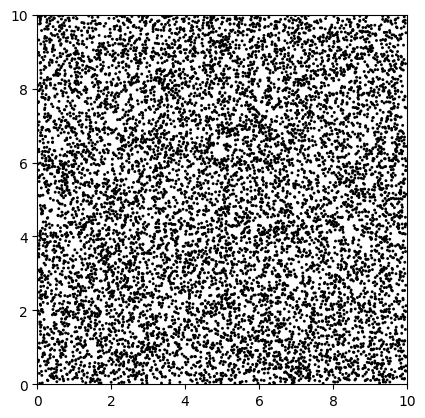

In [74]:
# Create a global simulation instance.
sim = ParticleSimulation(10000, width=WIDTH, height=HEIGHT)

In [75]:
def update(frame):
    """
    Animation update function.
    Each frame advances the simulation by a fixed time increment,
    processes any events, and updates the positions of the particle patches.
    """
    # Define the target simulation time for this frame.
    # Here, dt_frame sets how much simulation time each frame represents.
    dt_frame = 0.05
    target_time = sim.t + dt_frame
    sim.process_until(target_time)
    # Update the circle patch positions.
    return sim.update_patches()

In [ ]:
if __name__ == "__main__":
    # Set up the FuncAnimation.
    # interval=50 sets the delay between frames in milliseconds.
    anim = FuncAnimation(sim.fig, update, frames=150, interval=50, blit=True)
    anim.save("animation.mp4", writer='ffmpeg', fps=30)